In [0]:
import torch
from torch import nn
from torch.nn import functional as F
import cv2
import torchvision
import matplotlib.pyplot as plt
import numpy as np



In [20]:
model = torchvision.models.vgg19(pretrained=True).features
# freeze all VGG parameters since we're only optimizing the target image
for param in model.parameters():
    param.requires_grad_(False)
content_image_path = '/content/cat_content.jpg'
style_image_path = '/content/wavy_style.jpg'
device = 'cuda'
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def preprocess_from_path(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    transforms_ = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(size=[224, 224], interpolation=2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
    ])
    img = transforms_(img)
    # resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    # inp = torch.from_numpy(resized)
    # inp = inp.view(1, 3, 224, 224).to(device=device, dtype=torch.float)
    img = img.view(1, *img.shape)
    return img.to(device)

def display_image(tens):
    image = tens.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1', 
        '10': 'conv3_1', 
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def calculate_gram_matrix(inp_tensor):
    batch, d, h, w = inp_tensor.shape
    inp_tensor = inp_tensor.view(d, h * w)
    return torch.mm(inp_tensor, inp_tensor.t())


In [0]:
content_tensor = preprocess_from_path(content_image_path)
style_tensor = preprocess_from_path(style_image_path)

content_features = get_features(content_tensor, model)
style_features = get_features(style_tensor, model)

In [0]:
style_grams = {}
for feature in style_features:
    style_grams[feature] = calculate_gram_matrix(style_features[feature])

target_tensor = content_tensor.clone().requires_grad_(True).to(device)


In [0]:
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1  # alpha
style_weight = 1e6  # beta

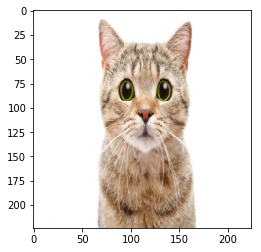

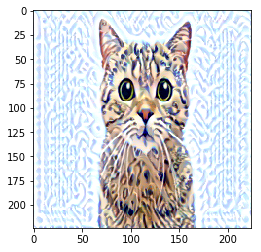

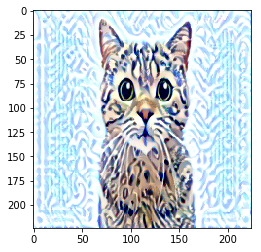

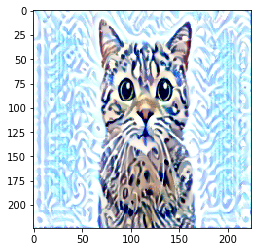

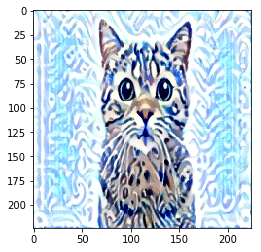

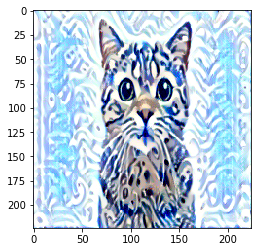

In [25]:
optim = torch.optim.Adam([target_tensor], lr=1e-2)
epochs = 1000

for epoch in range(0, epochs + 1):
    target_features = get_features(target_tensor, model)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = calculate_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    # update your target image
    optim.zero_grad()
    total_loss.backward()
    optim.step()

    if epoch % 200 == 0:
        plt.imshow(display_image(target_tensor))
        plt.show()

Original images:


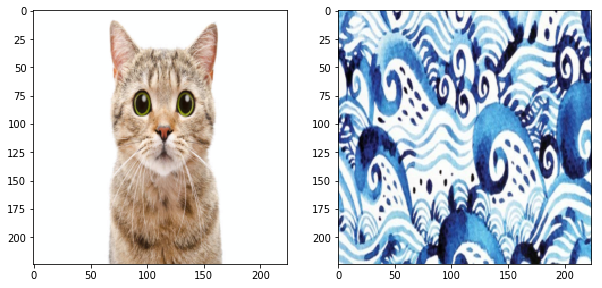

After style transfer:


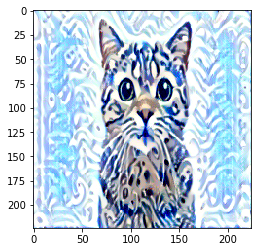

In [26]:
print('Original images:')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(display_image(content_tensor))
ax2.imshow(display_image(style_tensor))
plt.show()
print('After style transfer:')
plt.imshow(display_image(target_tensor))
plt.show()